In [1]:
import datetime

start = datetime.datetime.strptime("2018-12-10", "%Y-%m-%d")
end = datetime.datetime.strptime("2018-12-11", "%Y-%m-%d")
dates = [start + datetime.timedelta(hours=12*hd) for hd in range(0, (end-start).days*2)]

d = dates[1]
# Use 'requests' to download web data

import requests

url = 'http://weather.uwyo.edu/cgi-bin/sounding?region=pac&TYPE=TEXT%3ALIST&YEAR={:0>4d}&MONTH={:0>2d}&FROM={:0>2d}{:0>2d}&TO={:0>2d}{:0>2d}&STNM=94866'.format(d.year,d.month,d.day,d.hour,d.day,d.hour)

r = requests.get(url)
r.raise_for_status()

# The webpage is available in r.text:
# r.text

In [2]:
# Use 'beautifulsoup' to extract stuff from web pages

from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt

soup = BeautifulSoup(r.text, 'html.parser')

# Get the contents of the first <pre> tag from the html document
table = soup.find_all('pre')[0].text

print(table[0:1000])


-----------------------------------------------------------------------------
   PRES   HGHT   TEMP   DWPT   RELH   MIXR   DRCT   SKNT   THTA   THTE   THTV
    hPa     m      C      C      %    g/kg    deg   knot     K      K      K 
-----------------------------------------------------------------------------
 1006.0    119   14.2   11.2     82   8.37    190      6  286.9  310.4  288.3
 1001.0    159   15.0   11.3     79   8.47    186      7  288.1  312.0  289.5
 1000.0    167   14.8   11.2     79   8.42    185      7  287.9  311.7  289.4
  964.0    475   12.6    9.8     83   7.92    160     16  288.7  311.3  290.1
  946.0    634   11.4    9.0     85   7.68    150     15  289.1  311.0  290.5
  936.0    723   10.8    8.6     86   7.54    155     12  289.4  310.9  290.7
  925.0    822   10.6    6.9     78   6.79    160      9  290.1  309.7  291.3
  902.0   1032   10.2   -1.8     43   3.73    186     13  291.8  303.0  292.5
  894.0   1106   10.0    5.2     72   6.25    195     14  292.4

In [3]:
df = pd.read_fwf(io.StringIO(table), sep='\s+', skiprows=[0,1,3,4], header=0)
df['time'] = d
df['SKNT'] = df['SKNT']#*0.51444 #knots to metres/second
df[0:10]

,PRES,HGHT,TEMP,DWPT,RELH,MIXR,DRCT,SKNT,THTA,THTE,THTV,time
0,1006.0,119,14.2,11.2,82,8.37,190.0,6.0,286.9,310.4,288.3,2018-12-10 12:00:00
1,1001.0,159,15.0,11.3,79,8.47,186.0,7.0,288.1,312.0,289.5,2018-12-10 12:00:00
2,1000.0,167,14.8,11.2,79,8.42,185.0,7.0,287.9,311.7,289.4,2018-12-10 12:00:00
3,964.0,475,12.6,9.8,83,7.92,160.0,16.0,288.7,311.3,290.1,2018-12-10 12:00:00
4,946.0,634,11.4,9.0,85,7.68,150.0,15.0,289.1,311.0,290.5,2018-12-10 12:00:00
5,936.0,723,10.8,8.6,86,7.54,155.0,12.0,289.4,310.9,290.7,2018-12-10 12:00:00
6,925.0,822,10.6,6.9,78,6.79,160.0,9.0,290.1,309.7,291.3,2018-12-10 12:00:00
7,902.0,1032,10.2,-1.8,43,3.73,186.0,13.0,291.8,303.0,292.5,2018-12-10 12:00:00
8,894.0,1106,10.0,5.2,72,6.25,195.0,14.0,292.4,310.6,293.5,2018-12-10 12:00:00
9,892.0,1125,10.0,7.0,82,7.09,193.0,14.0,292.6,313.1,293.8,2018-12-10 12:00:00


Text(0.5, 1.0, 'Melb Airport Sounding 10 Dec 2018 11pm AEDT')

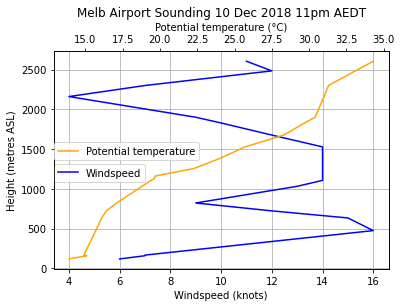

In [13]:
fig,ax1 = plt.subplots()

ax2 = ax1.twiny()

nrows = 20
temp_var = 'TEMP'

# ax1.plot(df[temp_var].loc[0:nrows], df['HGHT'].loc[0:nrows], label = temp_var + ' (C)', color = 'b')
# ax1.set_xlabel(temp_var + ' (C)')
# ax1.set_ylabel('Height (m)')
# ax1.legend(loc= [0,0.5])

# ax1.plot(df['DWPT'].loc[0:nrows], df['HGHT'].loc[0:nrows], label = 'Dew point (C)', color = 'r')
# ax1.set_xlabel('Degrees (C)')
# ax1.legend(loc = [0,0.4])

ax1.plot(df['SKNT'].loc[0:nrows], df['HGHT'].loc[0:nrows], label = 'Windspeed', color = 'blue')
ax1.set_xlabel('Windspeed (knots)')
ax1.legend(loc = [0,0.4])

ax2.plot(df['THTA'].loc[0:nrows]-273, df['HGHT'].loc[0:nrows], label = 'Potential temperature', color = 'orange')
ax2.set_xlabel('Potential temperature (\N{DEGREE SIGN}C)')
ax2.legend(loc = [0,0.5])

ax1.grid()
ax1.set_ylabel('Height (metres ASL)')
ax1.set_title('Melb Airport Sounding 10 Dec 2018 11pm AEDT')

In [15]:
def read_month(date):
    """
    Read a full month of sounding data
    """
    
    # Last day of the current month
    end_day = (date+pd.offsets.MonthEnd()).day
    end_month = (date+pd.offsets.MonthEnd()).month
    end_year = (date+pd.offsets.MonthEnd()).year
    url = f'http://weather.uwyo.edu/cgi-bin/sounding?region=pac&TYPE=TEXT%3ALIST&YEAR={end_year}&MONTH={end_month}&FROM=0100&TO={end_day}12&STNM=94866' #Melb airport - 94866, Wagga - 94910

    r = requests.get(url)
    r.raise_for_status()
    
    soup = BeautifulSoup(r.text, 'html.parser')
    
    dfs = []
    
    # Pass the heading (containing the date) and the table data to read_table()
    for head, table in zip(soup.find_all('h2'), soup.find_all('pre')[::2]):
        dfs.append(read_table(head.text, table.text))
        
    return pd.concat(dfs, ignore_index=True)

def read_table(head, table):
    """
    Convert the text table to a pandas DataFrame
    
    You might also want to interpolate to standard pressure levels here
    """
    df = pd.read_fwf(io.StringIO(table), sep='\s+', skiprows=[0,1,3,4], header=0)
    time = datetime.datetime.strptime(head[-15:],'%HZ %d %b %Y')
    df['time'] = time
    return df

In [16]:
import datetime
# Read for 2015-2018
melb_sounding = [] # wagga
for t in range(2015,2019):
    for i in range(1,13):
        melb_sounding.append(read_month(datetime.date(t,i,1)))

    
melb_sounding = pd.concat(melb_sounding, ignore_index = True)

HTTPError: 503 Server Error: Service Unavailable for url: http://weather.uwyo.edu/cgi-bin/sounding?region=pac&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=5&FROM=0100&TO=3112&STNM=94866

In [ ]:
melb_sounding = melb_sounding.set_index(['HGHT','time'])
melb_sounding = melb_sounding[~melb_sounding.index.duplicated()]

In [ ]:
ds = melb_sounding.to_xarray()
levels = np.arange(0,1500,100)
ds_regrid = ds.interpolate_na('HGHT').interp(HGHT=levels) # Interpolate to consistent height levels

height_filt = ds_regrid['HGHT'] <= 1500
boundary_layer = ds_regrid.where(height_filt)
ws_1500 = (boundary_layer.SKNT)*0.51444 # convert to m/s from knots
ws_1500.plot(ylim = (0,1500))

In [ ]:
pot_temp = boundary_layer.THTA
ws_1500 = ws_1500.dropna(dim = 'time', how = 'all') # Drop NaNs so argmax() function will work
pot_temp = pot_temp.where(ws_1500 == True)

profmax_ind = ws_1500[1:14,:].argmax(axis = 0) + 1 # must add 1 if starting at index = 1
profmax_ind_above = profmax_ind + 1
profmax_ind_below = profmax_ind - 1 

wsabove = ws_1500.isel(HGHT = profmax_ind_above) #windspeed above max evaluated on HGHT axis
profmax = ws_1500.isel(HGHT = profmax_ind)
wsbelow = ws_1500.isel(HGHT = profmax_ind_below) #windspeed below

In [118]:
pot_temp.where(ws_1500.time==True)

<xarray.DataArray 'THTA' (HGHT: 15, time: 2768)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 ... 2018-12-31T12:00:00
  * HGHT     (HGHT) int64 0 100 200 300 400 500 ... 900 1000 1100 1200 1300 1400

In [14]:
# # variable criteria algorithm

variable_criteria = 0.1 # windspeed above and below is more than x% below the maxima
fixed_criteria = 1
percent =  1 - variable_criteria 

speed_crit = profmax > 7 #m/s to knots
below_crit = wsbelow <= percent * profmax
above_crit = wsabove <= percent * profmax
temp_crit = pot_temp.isel(HGHT = 100) < pot_temp.isel(HGHT = profmax_ind)

jbv_sounding = (speed_crit & below_crit & above_crit & temp_crit) * 1

# fixed criteria algorithm
jbf_sounding = ((profmax - wsabove >= fixed_criteria) & (profmax - wsbelow >= fixed_criteria)) * 1

# sounding data
print(jbv_sounding.sum())
print(jbf_sounding.sum())

NameError: name 'profmax' is not defined

In [7]:
import xarray
from datetime import datetime, timedelta

wind_facilities = pd.read_csv('wind-facilities.csv')
data = xarray.open_dataset('/g/data/v46/lh2344/LLJ_2015_18.nc')
jetnight = xarray.open_dataset('/g/data/v46/lh2344/jetnights')

windlat = wind_facilities.Latitude
windlong = wind_facilities.Longitude

dstart = datetime(2015,1,1,0,0,0)
ndays = (365*3)+366
nj = 40
ni = 83
nt = ndays*24

jstart = 241
jend = jstart + nj
istart = 690
iend = istart + ni
pstart = 28
pend = 37
plevels = pend-pstart
heights_std = np.arange(100.0,1200.0,100.0)

jetnight2 = jetnight.jetnight2
ws100m_jn = jetnight.ws100m_jn
ws100m_nonjn = jetnight.ws100m_nonjn
jetnight_sum = jetnight2.sum(axis=0)
wsprof_interp = data.wsprof_interp

lon2d = data.lon2d
lat2d = data.lat2d
topog = xarray.open_dataset('Downloads/topog-an-slv-PT0H-BARRA_R-v1-20150207T0000Z.nc')
topog = topog.topog
topog = topog[jstart:jend,istart:iend]

profmax_ind = data.profmax_ind
profmax = data.profmax
wsabove = data.wsabove
wsbelow = data.wsbelow

coords_isosurf={
    wsprof_interp.dims[0]:wsprof_interp.coords[wsprof_interp.dims[0]],   # time name and dimension
    wsprof_interp.dims[2]:wsprof_interp.coords[wsprof_interp.dims[2]],   # latitude name and dimension
    wsprof_interp.dims[3]:wsprof_interp.coords[wsprof_interp.dims[3]]    # longitude name and dimension
}

speed_crit_reanalysis = profmax > 7 #m/s to knots
below_crit_reanalysis = wsbelow <= percent * profmax
above_crit_reanalysis = wsabove <= percent * profmax

jetbinary_variable = (speed_crit_reanalysis & below_crit_reanalysis & above_crit_reanalysis) * 1

# fixed criteria algorithm
jetbinary_fixed = ((profmax - wsabove >= fixed_criteria) & (profmax - wsbelow >= fixed_criteria)) * 1

jbv_reanalysis = jetbinary_variable.isel(time = ((jetbinary_variable.time.dt.hour==0)|(jetbinary_variable.time.dt.hour==12)))
jbf_reanalysis = jetbinary_fixed.isel(time = ((jetbinary_fixed.time.dt.hour==0)|(jetbinary_fixed.time.dt.hour==12)))

#reanalysis data
print(jbv_reanalysis[:,8,36].sum())
print(jbf_reanalysis[:,8,36].sum())

NameError: name 'percent' is not defined

<BarContainer object of 2 artists>

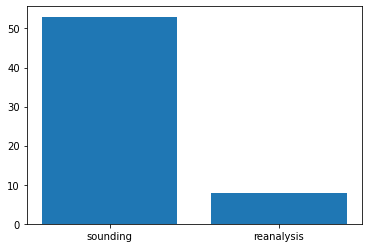

In [47]:
plt.bar(['sounding','reanalysis'], [jbv_sounding.sum(),jbv_reanalysis[:,8,36].sum()])

In [12]:
date = wsprof_interp.time == datetime(2016,1,1,0,0,0)
wsprof_interp[...,30,60]

<xarray.DataArray 'wsprof_interp' (time: 35064, isosurf: 11)>
[385704 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 ... 2018-12-31T23:00:00
  * isosurf    (isosurf) float64 100.0 200.0 300.0 400.0 ... 900.0 1e+03 1.1e+03
    latitude   int64 30
    longitude  int64 60

In [13]:
# wsprof_interp[...,8,37].where(wsprof_interp.time == datetime(2016,1,1,0,0,0))
ws1500_time = ws_1500.where(ws_1500.time == datetime(2015,2,1,0,0,0), drop = True)
wsprof_interp[...,30,60].sel(time = datetime(2015,2,1,0,0,0))

<xarray.DataArray 'wsprof_interp' (isosurf: 11)>
array([2.767515, 2.924375, 3.039927, 3.023008, 3.006089, 2.929602, 2.849828,
       2.814286, 2.804978, 2.79567 , 2.786362])
Coordinates:
    time       datetime64[ns] 2015-02-01
  * isosurf    (isosurf) float64 100.0 200.0 300.0 400.0 ... 900.0 1e+03 1.1e+03
    latitude   int64 30
    longitude  int64 60

In [14]:
ws_1500.time[0:30]


<xarray.DataArray 'time' (time: 30)>
array(['2015-01-01T00:00:00.000000000', '2015-01-01T12:00:00.000000000',
       '2015-01-02T00:00:00.000000000', '2015-01-02T12:00:00.000000000',
       '2015-01-03T00:00:00.000000000', '2015-01-03T12:00:00.000000000',
       '2015-01-04T00:00:00.000000000', '2015-01-04T12:00:00.000000000',
       '2015-01-05T00:00:00.000000000', '2015-01-05T12:00:00.000000000',
       '2015-01-06T00:00:00.000000000', '2015-01-06T12:00:00.000000000',
       '2015-01-07T00:00:00.000000000', '2015-01-07T12:00:00.000000000',
       '2015-01-08T00:00:00.000000000', '2015-01-08T12:00:00.000000000',
       '2015-01-09T00:00:00.000000000', '2015-01-09T12:00:00.000000000',
       '2015-01-10T00:00:00.000000000', '2015-01-10T12:00:00.000000000',
       '2015-01-11T00:00:00.000000000', '2015-01-11T12:00:00.000000000',
       '2015-01-12T00:00:00.000000000', '2015-01-12T12:00:00.000000000',
       '2015-01-13T00:00:00.000000000', '2015-01-13T12:00:00.000000000',
       '2015-01-14T00:00:00.000000000', '2015-01-14T12:00:00.000000000',
       '2015-01-15T00:00:00.000000000', '2015-01-15T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 ... 2015-01-15T12:00:00

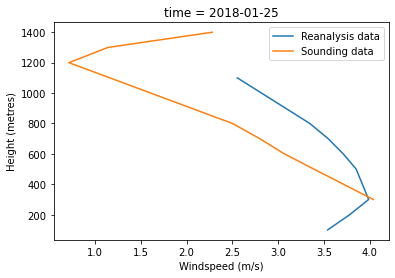

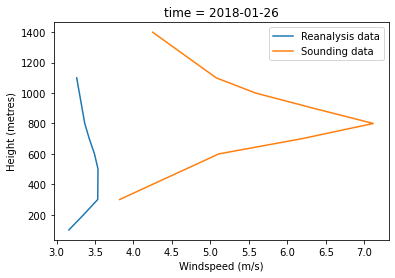

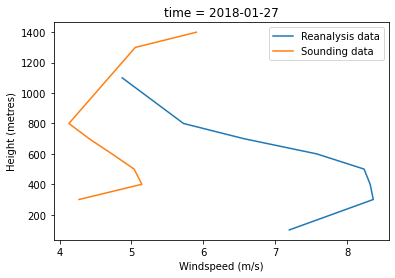

<xarray.DataArray 'time' ()>
array('2018-01-27T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time       datetime64[ns] 2018-01-27
    latitude   int64 30
    longitude  int64 60
<xarray.DataArray 'time' ()>
array('2018-01-27T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-01-27


In [27]:
for t in range(25,28):
    time = datetime(2018,1,t,0,0,0)
    wsprof_time = wsprof_interp[...,30,60].sel(time = time)
    ws1500_time = ws_1500.sel(time = time)

    # wsprof_interp[wsprof_time,:,8,37].plot(y = 'isosurf', label = 'Reanalysis data') # for plotting individual profiles
    # ws_1500[:,ws1500_time].plot(y = 'HGHT', label = 'Sounding data')
    wsprof_time.plot(y = 'isosurf', label = 'Reanalysis data')
    ws1500_time.plot(y = 'HGHT', label = 'Sounding data')
    plt.ylabel('Height (metres)')
    plt.xlabel('Windspeed (m/s)')
    plt.legend()
    plt.show()

print(wsprof_time.time)
print(ws1500_time.time)